<a href="https://colab.research.google.com/github/askmuhsin/Session_5_assignment/blob/main/Experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target:
* Reduce some parameters in early blocks, and assign more towards later blocks.
	* Reduced channels in block 1, 2, 3 (Transition) as 6, 12, 7
	* Increased channels in block 4, 5, 6, 7 as 16, 16, 18, 18.

# Results:
* Parameters: 9,958
* Best Training Accuracy: 98.84% (EPOCH 15)
* Best Test Accuracy: 99.46% (EPOCH 14)

# Analysis:
* model has improved, and can see more stable test accuracy after epoch 15.
* it is still underfitting

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=7, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

         # CONVOLUTION BLOCK 5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
         # CONVOLUTION BLOCK 6
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 6
         # CONVOLUTION BLOCK 7
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        # self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = self.convblock3(x)
        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
           Dropout-4            [-1, 6, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [25]:
# from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.10522403568029404 Batch_id=468 Accuracy=84.14: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0947, Accuracy: 9740/10000 (97.40%)

EPOCH: 1


Loss=0.0698951855301857 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:15<00:00, 30.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9808/10000 (98.08%)

EPOCH: 2


Loss=0.19299577176570892 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9869/10000 (98.69%)

EPOCH: 3


Loss=0.0899013951420784 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


Loss=0.0259933490306139 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.04369640350341797 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9880/10000 (98.80%)

EPOCH: 6


Loss=0.06928219646215439 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 31.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.013815280981361866 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.052752237766981125 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.022639190778136253 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.0675123929977417 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.02430322952568531 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.11793390661478043 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.04486847296357155 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.06410770863294601 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.04345615208148956 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.015819577500224113 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.020407965406775475 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.010536235757172108 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.003066849196329713 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]



Test set: Average loss: 0.0204, Accuracy: 9929/10000 (99.29%)



# Let's Train and test our model

Text(0.5, 1.0, 'Test Accuracy')

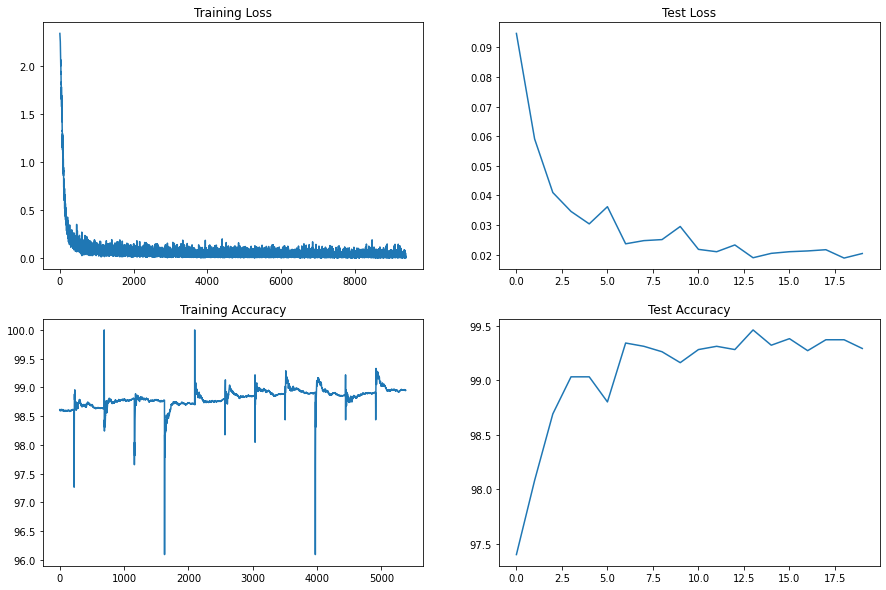

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [27]:
import pandas as pd

In [28]:
df = pd.DataFrame()
df['batch_avg_train_acc'] = pd.DataFrame(train_acc).rolling(469).mean().dropna()[::469].reset_index(drop=True)[0]
df['train_acc'] = pd.DataFrame(train_acc)[468::469].reset_index(drop=True)[0]
df['test_acc'] = pd.DataFrame(test_acc)
df['train_losses'] = pd.DataFrame([x.item() for x in train_losses])[468::469].reset_index(drop=True)[0]
df['test_losses'] = pd.DataFrame(test_losses)
df[['test_acc', 'train_acc', 'batch_avg_train_acc', 'train_losses', 'test_losses']]

,test_acc,train_acc,batch_avg_train_acc,train_losses,test_losses
0,97.40,84.141667,64.980795,0.105224,0.094728
1,98.08,96.946667,96.574214,0.069895,0.059079
2,98.69,97.651667,97.368449,0.192996,0.040969
3,99.03,98.071667,98.068110,0.089901,0.034583
4,99.03,98.235000,98.318673,0.025993,0.030378
5,98.80,98.305000,98.336936,0.043696,0.036184
6,99.34,98.513333,98.550762,0.069282,0.023646
7,99.31,98.626667,98.558368,0.013815,0.024721
8,99.26,98.601667,98.640481,0.052752,0.025073
9,99.16,98.643333,98.672235,0.022639,0.029499


In [35]:
max_test_epoch = 13
df[['test_acc', 'train_acc']][max_test_epoch - 3:max_test_epoch + 6]

,test_acc,train_acc
10,99.28,98.801667
11,99.31,98.778333
12,99.28,98.715000
13,99.46,98.786667
14,99.32,98.841667
15,99.38,98.896667
16,99.27,98.913333
17,99.37,98.866667
18,99.37,98.910000


In [33]:
df[:15].max()

batch_avg_train_acc    98.860701
train_acc              98.841667
test_acc               99.460000
train_losses            0.192996
test_losses             0.094728
dtype: float64

In [21]:
df.min()

batch_avg_train_acc    72.971340
train_acc              88.308333
test_acc               97.100000
train_losses            0.004588
test_losses             0.020458
dtype: float64

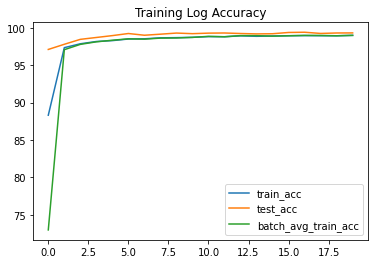

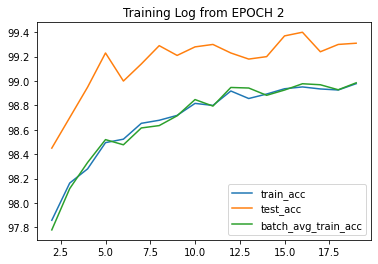

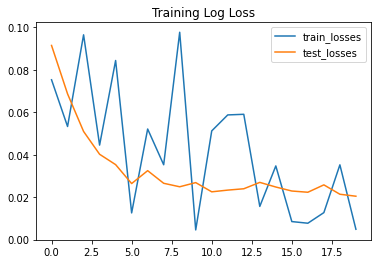

In [22]:
df[['train_acc', 'test_acc', 'batch_avg_train_acc']].plot(title="Training Log Accuracy")
df[['train_acc', 'test_acc', 'batch_avg_train_acc']][2:].plot(title="Training Log from EPOCH 2")
df[['train_losses', 'test_losses']].plot(title="Training Log Loss")

In [16]:
df[15:].var()

batch_avg_train_acc    0.000792
train_acc              0.000415
test_acc               0.003930
train_losses           0.000151
test_losses            0.000004
dtype: float64